In [1]:
# Around 10% of the tokens don't occur in the vocab generated by BPE.
# They were used to construct the vocab, but only their downstream tokens are used, not these intermediate tokens.
# e.g. machin => machine; "machin" is unused during construction, but only "machine" appears in texts.
# Around 10%@50k, 10%@25k

In [2]:
import json
from tokenizer import SpaceTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [3]:
with open('tokenizers/tokenizer-space.json', 'r', encoding='utf-8') as f: tokenizer_config = json.load(f)

vocab_size = 20000 + 257
vocab_size_pre_removal = int(vocab_size * 1.1)
tokenizer = SpaceTokenizer(tokenizer_config["model"]["vocab"], vocab_size_pre_removal)

In [4]:
dataset = load_dataset("wikitext", "wikitext-103-raw-v1", split="train+test+validation") # split="train+test+validation"

def batch_iterator(batch_size=1000):
    for i in range(0, len(dataset), batch_size):
        yield dataset[i : i + batch_size]["text"]

In [5]:
ids = []
for batch in tqdm(batch_iterator(), total=int(len(dataset) / 1000)):
    token_ids, token_values = tokenizer.encode(" ".join(batch), return_token_tuple=True)
    ids.extend(token_ids)
print(len(ids))

1810it [04:39,  6.47it/s]

114966111


In [6]:
df_ids = pd.DataFrame(ids, columns=["id"])
df_ids['id'] = df_ids['id'] // 4
df_ids = df_ids['id'].value_counts().rename_axis('id').reset_index(name='counts')
print(df_ids)

          id   counts
0        259  6472784
1         12  4993207
2         14  3930569
3        273  2758490
4        272  2522641
...      ...      ...
21991  12127        1
21992   9146        1
21993   6436        1
21994   5027        1
21995   3346        1

[21996 rows x 2 columns]


In [7]:
df_ids.to_csv("data/tmp/wikitext-token-count.csv", index=False)

In [8]:
df_counts = pd.read_csv("data/tmp/wikitext-token-count.csv", index_col="id")
df_counts

,counts
id,
259,6472784
12,4993207
14,3930569
273,2758490
272,2522641
...,...
12127,1
9146,1
6436,1


In [9]:
df_vocab = pd.DataFrame.from_dict(tokenizer_config["model"]["vocab"], orient='index')
df_vocab = df_vocab[0:vocab_size_pre_removal]
df_vocab = df_vocab.reset_index()
df_vocab.columns=['token', 'id']
df_vocab = df_vocab.set_index("id")
df_vocab

,token
id,
0,<|endoftext|>
1,!
2,""""
3,#
4,$
...,...
22277,thrilling
22278,trenchard
22279,quincy


In [10]:
merged_df = pd.merge(df_vocab, df_counts, on='id', how='left')
merged_df['counts'] = merged_df['counts'].fillna(0)
merged_df['counts'] = merged_df['counts'].astype(int)
merged_df

,token,counts
id,,
0,<|endoftext|>,0
1,!,17919
2,"""",1343602
3,#,4824
4,$,46944
...,...,...
22277,thrilling,396
22278,trenchard,388
22279,quincy,387


In [11]:
df_special = merged_df[0:257]
df_tokens = merged_df[257:]
df_tokens

,token,counts
id,,
257,th,99492
258,in,1937156
259,the,6472784
260,an,363404
261,er,87622
...,...,...
22277,thrilling,396
22278,trenchard,388
22279,quincy,387


In [12]:
df_tokens_sorted = df_tokens.sort_values(by='counts', ascending=False)
df_tokens_sorted

,token,counts
id,,
259,the,6472784
273,of,2758490
272,and,2522641
275,to,2013922
258,in,1937156
...,...,...
1836,attemp,0
16419,aparte,0
6221,extin,0


In [13]:
df_sorted_vocab = pd.concat([df_special, df_tokens_sorted])
df_sorted_vocab

,token,counts
id,,
0,<|endoftext|>,0
1,!,17919
2,"""",1343602
3,#,4824
4,$,46944
...,...,...
1836,attemp,0
16419,aparte,0
6221,extin,0


In [14]:
df_export_vocab = df_sorted_vocab.reset_index().set_index("token")
df_export_vocab = df_export_vocab[0:vocab_size]
df_export_vocab["id"] = range(len(df_export_vocab))
df_export_vocab["id"].to_json("tokenizers/tokenizer-space-20k-rs.json", orient='index', indent=4, force_ascii=False)

In [15]:
df_removed = df_sorted_vocab[vocab_size:]
df_removed["token"].to_csv("data/tmp/scaffold-removed.txt", index=False)

#### Plot token occurrence

In [16]:
df = df_sorted_vocab

min_count = 40
small_count = len(df[df["counts"] <= min_count])
print(small_count / len(df), len(df) - small_count, len(df))

0.04335337940938874 21316 22282


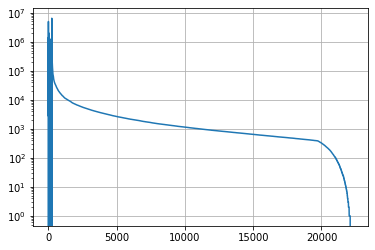

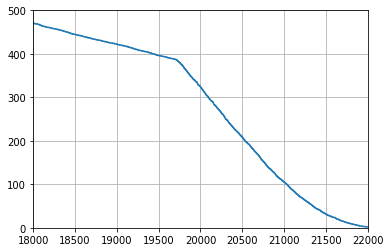

In [18]:
plt.plot(range(len(df)), df["counts"])
plt.yscale("log")
plt.grid()
plt.show()

plt.plot(range(len(df)), df["counts"])
plt.grid()
plt.xlim(18000, 22000)
plt.ylim(0, 500)
plt.show()